# Распаковка файлов

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1tRrkTL_mo3fqrcppHHOd-y4JMIHh-opz/view?usp=sharing -O comments.json.gz

Downloading...
From (original): https://drive.google.com/uc?id=1tRrkTL_mo3fqrcppHHOd-y4JMIHh-opz
From (redirected): https://drive.google.com/uc?id=1tRrkTL_mo3fqrcppHHOd-y4JMIHh-opz&confirm=t&uuid=0f7f6c74-d6bc-48d8-85e0-3c0902c2daaa
To: /content/comments.json.gz
100% 106M/106M [00:03<00:00, 34.8MB/s]


In [ ]:
!gunzip comments.json.gz

# Считываем текстовые данные

In [ ]:
import pandas as pd
import json

with open('comments.json', 'r') as fp:
    texts = json.load(fp)

texts = [line['content'] for line in texts]
texts = pd.Series(texts)
texts = texts[texts.notna()]

In [ ]:
texts.head()

,0
0,"Лечила кариес у Литвиновой. Неплохой врач, акк..."
1,Ставила коронку у доктора Гросул. Ошибок в его...
2,"Все очень понравилось, после похода в клинику ..."
3,"Боялась зубных врачей. Но пришло время, и сред..."
4,Врач от бога. Очень благодарна нашему доктору ...


In [ ]:
texts.info()

<class 'pandas.core.series.Series'>
Index: 369880 entries, 0 to 388785
Series name: None
Non-Null Count   Dtype 
--------------   ----- 
369880 non-null  object
dtypes: object(1)
memory usage: 5.6+ MB


В зависимости от размеров обучающих данных, будет зависеть время обучения модели.

Для примера на 350к данных обучение на Т4 будет проходить 5 часов.

Для проверки работы алгоритм возьмем случайный сэмпл данных на 10к значений.

In [ ]:
texts = texts.sample(10_000, random_state=42)

# Задание 1

Обучить WordPiece токенизатор на неразмеченной части корпуса RuDReC, состоящем из отзывов пользователей о лекарственных препаратах на русском языке. Размер словаря - 10 000 токенов. Сохранить токенизатор.

### Создатим метод для обучения токенайзера

Стоит отметить, что для корректной работы модели и токенайзера нам потребуются специальные токены. Они помогают модели лучше понимать структуру и смысл входных данных.

В данном примере будут использоваться специальные токены из [BERT-like](https://huggingface.co/docs/transformers/model_doc/bert) моделей.

---

**Описание токенов:**

1. `[PAD]` (Padding Token)

**Назначение**: Используется для выравнивания последовательностей до одинаковой длины в батче. Это важно для параллельной обработки данных.

**Пример**: Если одна последовательность содержит 10 токенов, а другая — 15, первая будет дополнена 5 `[PAD]` токенами.

2. `[UNK]` (Unknown Token)

**Назначение**: Замещает неизвестные или редко встречающиеся слова, которые не входят в словарь токенизатора.

**Пример**: Если токенизатор наткнулся на слово, которого нет в его словаре, оно будет заменено на `[UNK]`.

3. `[CLS]` (Classification Token)

**Назначение**: Используется как специальный токен в задачах классификации. Обычно располагается в начале последовательности и служит агрегатором информации для классификационной задачи.

**Пример**: В BERT модели `[CLS]` токен используется для получения представления всей последовательности.

4. `[SEP]` (Separator Token)

**Назначение**: Разделяет разные части входных данных, например, предложения или сегменты текста.

**Пример**: В задачах понимания отношений между предложениями `[SEP]` разделяет два предложения.

5. `[MASK]` (Mask Token)

**Назначение**: Используется в задачах маскированного языкового моделирования, где модель учится предсказывать скрытые (замаскированные) слова.

**Пример**: В задаче предсказания пропущенных слов предложение "Я люблю `[MASK]`" модель должна предсказать, что на месте `[MASK]` может быть слово "программировать".

In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers

def train_tokenizer(
    texts: list,
    vocab_size: int = 10000,
    save_path: str = 'tokenizer.json',
    special_tokens: list = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
) -> Tokenizer:
    """
    Обучаем токенайзер на входных данных.

    1) Инициализируем токенайзер с моделью WordPiece.
    2) Устанавливаем нормализаторы для предобработки текста.
    3) Устанавливаем претокенизатор (разбивка по пробелам).
    4) Настраиваем trainer для обучения.
    5) Обучаем токенайзер на предоставленных текстах.
    6) Сохраняем обученный токенайзер.

    Входные параметры:
    - texts (list): Список текстов для обучения.
    - vocab_size (int): Размер словаря.
    - save_path (str): Путь для сохранения токенизатора.
    - special_tokens (list): Список специальных токенов.

    Возвращает:
    - Tokenizer: Обученный токенизатор.
    """
    tokenizer = Tokenizer(models.WordPiece(unk_token=special_tokens[0]))

    tokenizer.normalizer = normalizers.Sequence([
        # Преобразует текст в нормальную форму декомпозиции (NFD),
        # разделяя составные символы и диакритические знаки
        normalizers.NFD(),

        # Преобразует все символы текста в нижний регистр,
        # обеспечивая согласованность при обработке
        normalizers.Lowercase(),

        # Удаляет диакритические знаки (акценты) из символов,
        # упрощая дальнейшую обработку текста
        normalizers.StripAccents()
    ])

    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    trainer = trainers.WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=special_tokens
    )

    tokenizer.train_from_iterator(texts, trainer=trainer)
    tokenizer.save(save_path)
    return tokenizer

In [ ]:
%%time
tokenizer = train_tokenizer(texts)

CPU times: user 3.62 s, sys: 183 ms, total: 3.8 s
Wall time: 2.12 s


In [ ]:
# Проверим работоспособность
tokenizer.encode('Кодировщик на трансформерах').tokens

['ко',
 '##ди',
 '##ров',
 '##щи',
 '##к',
 'на',
 'транс',
 '##фор',
 '##мер',
 '##а',
 '##х']

# Задание 2

Выбрать 1k наиболее частотных токенов, подсчитав статистику на неразмеченной части корпуса RuDReC.

In [ ]:
from collections import Counter

def get_top_k_tokens(tokenizer: Tokenizer, texts: list, k: int = 1000) -> list:
    """
    Извлекает топ-`k` наиболее часто встречающихся токенов из списка текстов с использованием заданного токенизатора.

    1) Проходим по списку текстов, токенизирует каждый текст с помощью предоставленного токенизатора.
    2) Подсчитываем количество появлений каждого токена и возвращает список из `k` наиболее частотных токенов.

    Входные параметры:
    - tokenizer (Tokenizer): Объект токенизатора.
    - texts (list): Список текстов для обучения.
    - k (int): Количество самых частотных токенов, которые необходимо вернуть.

    Возвращает:
    - list: Список из `k` наиболее часто встречающихся токенов.
    """
    token_counts = Counter()
    batch_size = 1000

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer.encode_batch(batch_texts.tolist())
        for encoding in encodings:
            tokens = encoding.tokens
            token_counts.update(tokens)

    top_k_tokens = [token for token, count in token_counts.most_common(k)]

    return top_k_tokens

In [ ]:
%%time
top_1000_tokens = get_top_k_tokens(tokenizer, texts, k=1000)
top_1000_tokens[0:10]

CPU times: user 3.82 s, sys: 7.16 ms, total: 3.82 s
Wall time: 3.26 s


[',', '.', 'и', 'в', 'не', '!', 'на', 'что', 'к', 'я']

# Задание 3

Расширить токенизатор модели mBERT, полученными на предыдущем шаге токенами.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

# Загрузка оригинального токенизатора и модели mBERT
model_name = 'bert-base-multilingual-cased'
source_tokenizer = BertTokenizer.from_pretrained(model_name)
source_model = BertForMaskedLM.from_pretrained(model_name)
source_model.eval()

In [ ]:
# Инициализируем новые модель и токенайзер
# Их мы будем расширять и учить
target_model = BertForMaskedLM.from_pretrained(model_name)
target_tokenizer = BertTokenizer.from_pretrained(model_name)

# Добавим в токенайзер новые токены
num_added_toks = target_tokenizer.add_tokens(top_1000_tokens)
print(f"Добавлено {num_added_toks} новых токенов в токенизатор.")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Добавлено 416 новых токенов в токенизатор.


# Задание 4

Инициализировать новые токены усредненным векторным представлением токенов, полученных при помощи разбиения новых токенов оригинальным токенизатором.

Пример: допустим, в новом токенизаторе один из частотных токенов оказался токен “капли”. Допустим, если разбить токен “капли” оригинальным токенизатором, получалось два токена “кап” и “ли”. Пусть e1 - векторное представление из слоя Embeddings модели mBERT для слова “кап”, а вектор e2 - для слова “ли”. Тогда в расширенном слое  Embeddings новый токен “капли” должен быть инициализирован вектором: (e1+e2)/2.

In [ ]:
import torch
import numpy as np

In [ ]:
def get_new_input_embeddings(
    source_tokenizer: BertTokenizer,
    target_tokenizer: BertTokenizer,
    source_model: BertForMaskedLM,
    top_1000_tokens: list
) -> np.ndarray:
    """
    Обновление токенизатора путем вычисления средних эмбеддингов из исходной модели.

    1) Получение словарей
    2) Перемещение исходной модели на устройство
    3) Получение эмбеддингов из исходной модели
    4) Инициализация эмбеддингов для целевой модели
    5) Обработка новых токенов
    5.1) Пропускаем токены, которые не в списке новых токенов
    5.2) Токенизируем новый токен с помощью исходного токенизатора
    5.3) Получаем эмбеддинги sub-токенов
    5.4) Вычисляем среднее эмбеддингов
    5.5) Добавляем новый эмбеддинг

    Входные параметры:
    - source_tokenizer (BertTokenizer): Оригинальный токенайзер BERT.
    - target_tokenizer (BertTokenizer): Расширенный токенайзер.
    - source_model (BertForMaskedLM): Оригинальная модель BERT. Из нее берем эмбеддинги.
    - top_1000_tokens (list): Самые популярные токены в RuDReC.

    Возвращает:
    - np.ndarray: Новые эмбеддинги токенов.
    """
    source_vocab = source_tokenizer.get_vocab()
    target_vocab = target_tokenizer.get_vocab()
    target_inverted_vocab = {v: k for k, v in target_vocab.items()}

    # Исходные эмбеддинги
    source_input_embeddings = source_model.get_input_embeddings()

    # Сохраняем исходные эмбеддинги в тензор
    input_embeddings = source_input_embeddings.weight.data

    # Список для новых эмбеддингов
    new_embeddings = []

    # Проходим по индексам новых токенов
    # Новые токены будут после исходного словаря
    for i in range(len(source_vocab), len(target_vocab)):
        target_token = target_inverted_vocab[i]

        # Проверяем, что токен в списке часто встречающихся
        if target_token not in top_1000_tokens:
            continue

        # Разбиваем новый токен исходным токенайзером
        sub_tokens = source_tokenizer.tokenize(target_token)
        sub_token_ids = source_tokenizer.convert_tokens_to_ids(sub_tokens)
        sub_token_ids = torch.tensor(sub_token_ids)

        # Получаем эмбеддинги sub-токенов
        sub_token_embeddings = input_embeddings[sub_token_ids]

        # Усредняем эмбеддинги вдоль оси sub-токенов
        mean_embedding = sub_token_embeddings.mean(dim=0)

        # Добавляем эмбеддинг в список
        new_embeddings.append(mean_embedding)

    # Если нет новых эмбеддингов, просто возвращаем исходные
    if len(new_embeddings) == 0:
        return input_embeddings.cpu().numpy()

    # Стек и конкатенация новых эмбеддингов к старым
    new_embeddings = torch.stack(new_embeddings, dim=0)
    final_embeddings = torch.cat([input_embeddings, new_embeddings], dim=0)

    # Возвращаем в формате numpy
    return final_embeddings.cpu().numpy()

In [ ]:
%%time
target_vocab = target_tokenizer.get_vocab()

input_embeddings = get_new_input_embeddings(
    source_tokenizer,
    target_tokenizer,
    source_model,
    top_1000_tokens
)

CPU times: user 356 ms, sys: 247 ms, total: 602 ms
Wall time: 625 ms


In [ ]:
# Изменяем размер эмбеддингов модели, чтобы включить новые токены
target_model.resize_token_embeddings(len(target_vocab))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(119963, 768, padding_idx=0)

In [ ]:
# Скопируем, чтобы проверить изменение весов
target_model_add_tokens_weight_data = target_model.get_input_embeddings().weight.data.clone()

In [ ]:
# Устанавливаем новые эмбеддинги
target_model.get_input_embeddings().weight.data = torch.tensor(input_embeddings)

In [ ]:
# Проверяем, что веса подцепились
torch.equal(
    target_model_add_tokens_weight_data,
    target_model.get_input_embeddings().weight.data
)

False

In [ ]:
target_model_add_tokens_weight_data

tensor([[ 2.5951e-02, -6.1734e-03, -4.0997e-03,  ...,  2.9652e-02,
          2.4176e-02,  1.9703e-02],
        [ 1.0381e-02, -1.3629e-02,  6.7208e-03,  ...,  1.2372e-02,
          2.6722e-02,  3.3707e-02],
        [ 2.2068e-02, -3.6061e-03,  1.9324e-02,  ...,  6.9061e-03,
          2.6809e-02,  4.9828e-03],
        ...,
        [-1.8411e-03, -1.7339e-02, -1.6989e-05,  ..., -3.9770e-04,
          1.2598e-04, -2.3740e-03],
        [-1.8403e-03, -1.7337e-02, -1.5321e-05,  ..., -3.9923e-04,
          1.2414e-04, -2.3770e-03],
        [-1.8413e-03, -1.7339e-02, -1.6750e-05,  ..., -3.9784e-04,
          1.2278e-04, -2.3770e-03]])

In [ ]:
target_model.get_input_embeddings().weight.data

tensor([[ 0.0260, -0.0062, -0.0041,  ...,  0.0297,  0.0242,  0.0197],
        [ 0.0104, -0.0136,  0.0067,  ...,  0.0124,  0.0267,  0.0337],
        [ 0.0221, -0.0036,  0.0193,  ...,  0.0069,  0.0268,  0.0050],
        ...,
        [-0.0428,  0.0295, -0.0067,  ..., -0.0065, -0.0138,  0.0246],
        [-0.0449,  0.0301,  0.0202,  ..., -0.0280,  0.0047, -0.0261],
        [-0.0136,  0.0302,  0.0295,  ..., -0.0243, -0.0240, -0.0060]])

# Задание 5

Обучить новую модель с расширенным токенизатором на задаче MLM на неразмеченной части корпуса RuDReC. Сохранить полученную модель.

In [ ]:
# Импортируем библиотеки для обучения
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
# Делим данные на Обучение, Валидацию и Тест
# Соотношения в каждом случае 80% на 20%
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=42)
train_texts, val_texts = train_test_split(train_texts, test_size=0.2, random_state=42)

In [ ]:
train_texts.shape, val_texts.shape, test_texts.shape

((6400,), (1600,), (2000,))

In [ ]:
from tqdm import tqdm

class TextDataset(Dataset):
    """
    Класс токенизирует входные тексты,
    которые могут быть использованы в DataLoader для обучения моделей.
    """
    def __init__(
        self,
        texts: list,
        tokenizer: BertTokenizer,
        block_size: int = 128
    ) -> None:
        self.examples = []
        for text in tqdm(texts):
            encoding = tokenizer(
                text,
                add_special_tokens=True,
                truncation=True,
                max_length=block_size,
                return_attention_mask=True,
                return_tensors='pt'
            )
            self.examples.append(encoding)

    def __len__(self) -> int:
        """
        Возвращает общее количество примеров в датасете.
        """
        return len(self.examples)

    def __getitem__(self, idx: int) -> dict:
        """
        Получает пример по указанному индексу.
        """
        return {
            'input_ids': self.examples[idx]['input_ids'].squeeze(0),
            'attention_mask': self.examples[idx]['attention_mask'].squeeze(0)
        }

In [ ]:
# Заменим название переменных на стандартные (Опционально)
# Просто приводим к стандартному названию
tokenizer = target_tokenizer
model = target_model

В памяти это не займет больше места, так как питон просто создает reference ссылку на данные объекты

Подробнеее про ячейки памяти и garbage collector

[Ссылка](https://sky.pro/wiki/python/garbage-collector-v-python-kak-eto-rabotaet/)

In [ ]:
# Создадим DataCollator для MLM
# -----------------------------
# Коллаторы данных - это объекты,
# которые формируют пакет, используя в качестве входных данных список
# элементов набора данных. Эти элементы имеют тот же тип, что и
# элементы train_dataset или eval_dataset.
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
%%time
# Создание объектов Dataset
block_size = 128  # Можно изменить по необходимости
train_dataset = TextDataset(train_texts, tokenizer, block_size=block_size)
val_dataset = TextDataset(val_texts, tokenizer, block_size=block_size)

100%|██████████| 1600/1600 [00:02<00:00, 732.70it/s]

CPU times: user 12 s, sys: 159 ms, total: 12.1 s
Wall time: 12.2 s


In [ ]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir='./mlm_model',           # Директория для сохранения модели
    overwrite_output_dir=True,          # Перезаписывать содержимое директории `output_dir`, если она уже существует
    num_train_epochs=3,                 # Количество эпох
    per_device_train_batch_size=32,     # Размер батча для обучения на одном устройстве
    per_device_eval_batch_size=32,      # Размер батча для оценки модели на одном устройстве
    save_steps=200,                     # Сохранение модели каждые 5000 шагов
    save_total_limit=2,                 # Максимальное количество сохраненных checkpoints
    eval_strategy='steps',              # 'steps' означает, что оценка будет проводиться каждые `eval_steps` шагов
    eval_steps=100,                     # Количество шагов между оценками модели
    logging_steps=100,                  # Количество шагов между логированием метрик
    learning_rate=5e-5,                 # Начальная скорость обучения для оптимизатора
    weight_decay=0.01,                  # Коэффициент для регуляризации веса для предотвращения переобучения
    prediction_loss_only=True,          # При оценке будет возвращаться только значение функции потерь
    report_to='none'                    # Чтобы не было отправлений отчетов. Без него требует api ключ
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
# Начинаем обучение модели
trainer.train()

Step,Training Loss,Validation Loss
100,3.301800,2.652675
200,2.553500,2.203305
300,2.237500,2.014513
400,2.073100,1.912281
500,1.961900,1.809871
600,1.908800,1.788414


TrainOutput(global_step=600, training_loss=2.3394188690185547, metrics={'train_runtime': 1103.7578, 'train_samples_per_second': 17.395, 'train_steps_per_second': 0.544, 'total_flos': 1264701962649600.0, 'train_loss': 2.3394188690185547, 'epoch': 3.0})

In [ ]:
# Сохранение модели и токенизатора
trainer.save_model('./mlm_model')
tokenizer.save_pretrained('./mlm_model')

('./mlm_model/tokenizer_config.json',
 './mlm_model/special_tokens_map.json',
 './mlm_model/vocab.txt',
 './mlm_model/added_tokens.json')

In [ ]:
import transformers


model = transformers.AutoModelForMaskedLM.from_pretrained('./mlm_model/checkpoint-600/')

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
# Оценка модели на тестовом наборе (опционально)
test_dataset = TextDataset(test_texts, tokenizer, block_size=block_size)
eval_result = trainer.evaluate(eval_dataset=test_dataset)
print(f"Perplexity: {torch.exp(torch.tensor(eval_result['eval_loss']))}")

100%|██████████| 2000/2000 [00:02<00:00, 704.00it/s]


Perplexity: 6.074899673461914


# <center id="a1"> Определение тональности комментариев с использованием BERT

In [ ]:
# Загружаем библиотеки
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pylab import rcParams
from IPython import display
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from nltk.tokenize import word_tokenize

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/13nPk0Og0B8XWXb6zSx8fq4E9lMutKusy/view?usp=sharing -O reviews.csv

Downloading...
From: https://drive.google.com/uc?id=13nPk0Og0B8XWXb6zSx8fq4E9lMutKusy
To: /content/reviews.csv
100% 6.45M/6.45M [00:00<00:00, 20.7MB/s]


In [ ]:
# Устанавливаем константы воспроизводимости и переменные для отображения графиков
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 10, 6

# Воспроизводимость
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Выбираем ускоритель GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Читаем данные
df = pd.read_csv('/content/reviews.csv')
df.shape

(12495, 12)

In [ ]:
# Смотрим на данные
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


Text(0.5, 0, 'review score')

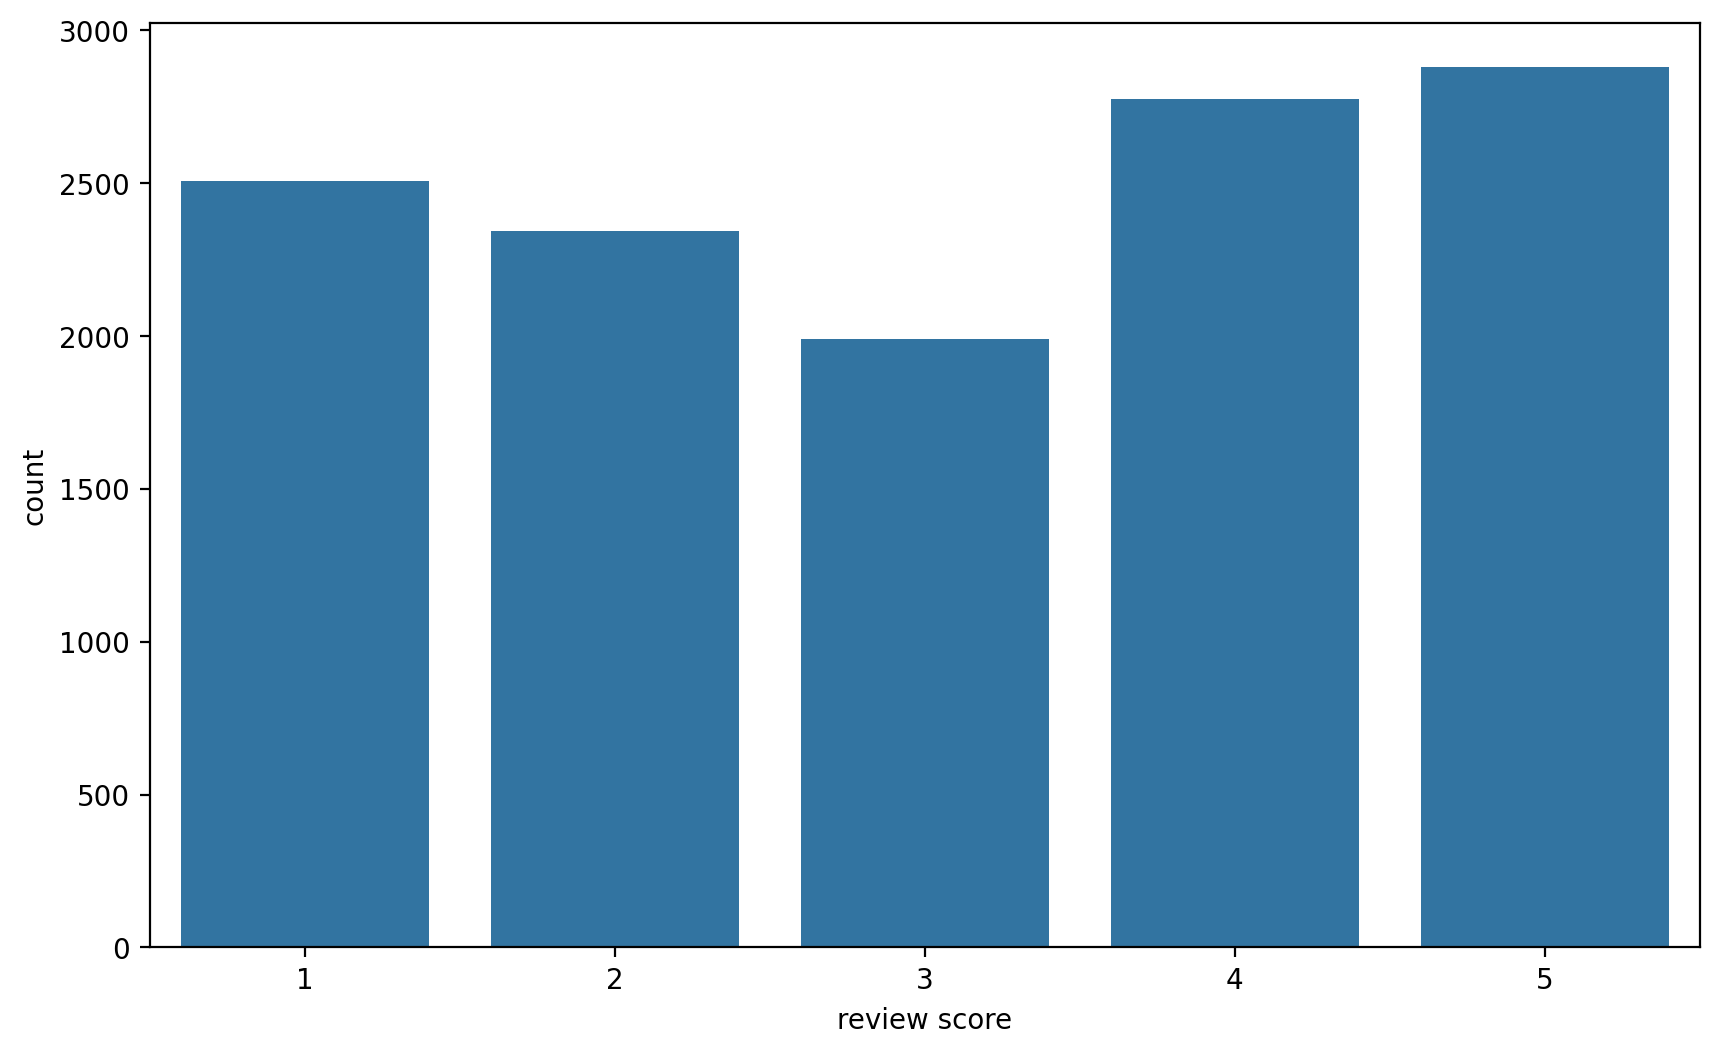

In [ ]:
# Смотрим на распределение классов
sns.countplot(df, x="score")
plt.xlabel('review score')

In [ ]:
# Функция кодировки эмоциональной окраски
def to_sentiment(rating):

    rating = int(rating)

    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

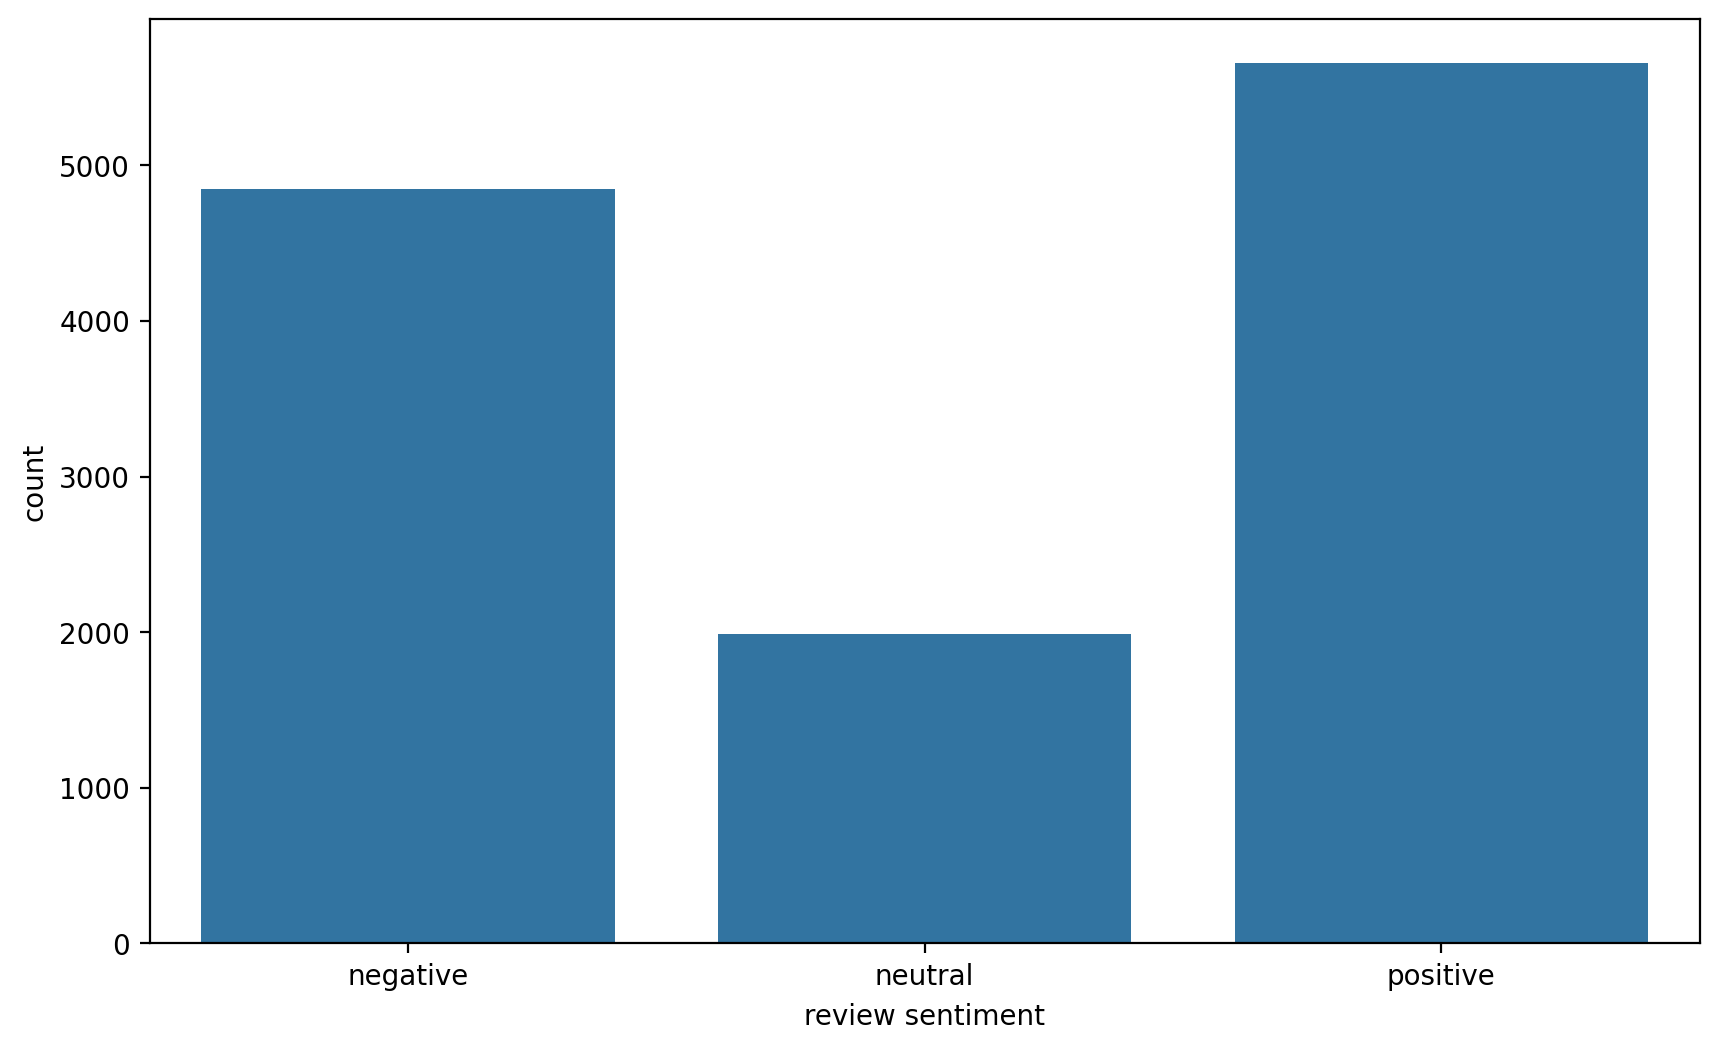

In [ ]:
# Отрисовываем распределение целевой переменной
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df, x="sentiment")
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

<div class="alert alert-info">
    
Видим, что у нас 3 класса: негативная тональность, позитивная и нейтральная.

In [ ]:
# Загружаем токенизатор модели
MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Используемые токенизатором BERT токены
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# Считаем длину каждого отзыва
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

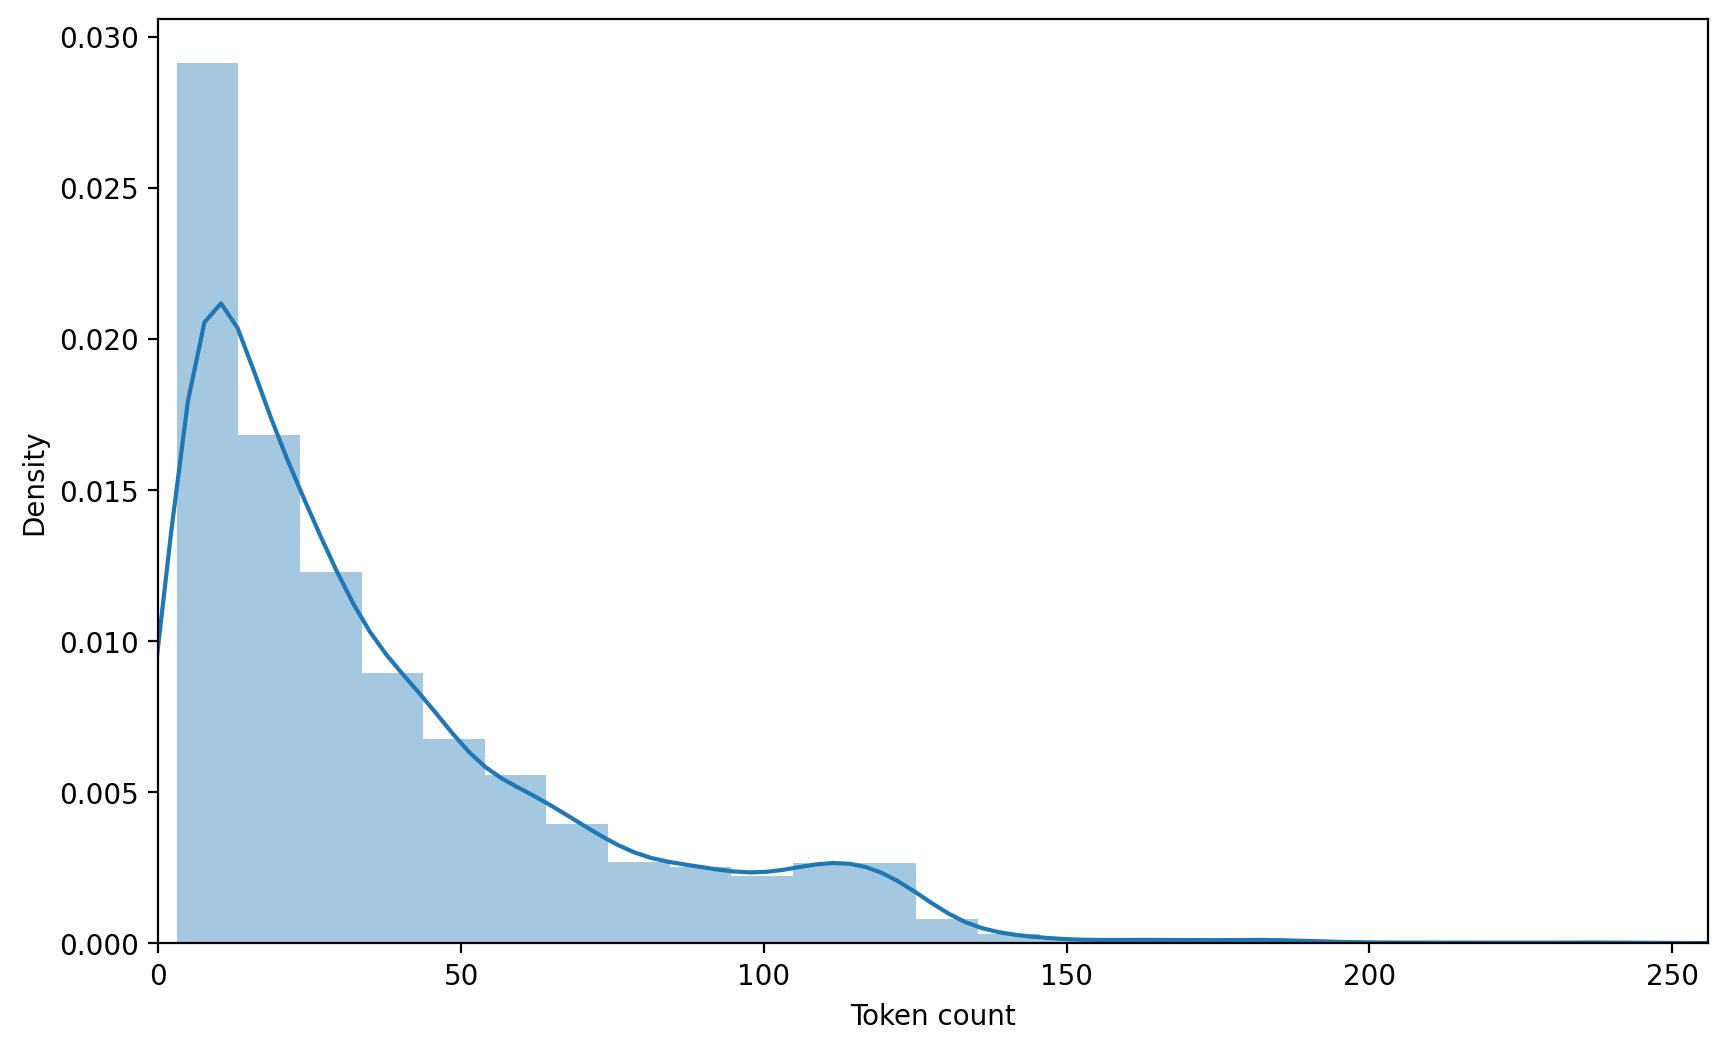

In [ ]:
# Отрисуем длины отзывов
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

<div class="alert alert-info">

Видим, что в целом все отзывы укладываются в примерно 150 токенов. Значит, можно выставить максимальную длину.

In [ ]:
# Установим максимальную длину
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Определяем атрибуты
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Метод подсчета длины
    def __len__(self):
        return len(self.reviews)

    # Метод возврата индекса
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Кодирование
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# Разбиваем на обучающую и валидационную выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(9996, 13) (1249, 13) (1250, 13)


In [ ]:
# Функция создания загрузчика данных
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
BATCH_SIZE = 128
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Посмотрим, как выглядят данные перед загрузкой в модель
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([128, 160])
torch.Size([128, 160])
torch.Size([128])


In [ ]:
# Загружаем модель
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

    # Создаем атрибуты
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Прямой проход
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output
        # Добавим слой dropout
        output = self.drop(pooled_output)
        return self.classifier(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Проверяем размерность скрытого представления
print(bert_model.config.hidden_size)

768


In [ ]:
EPOCHS = 3

# Оптимизатор Adam
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

# Планировщик скорости обучения
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Устанавливаем функцию потерь
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Функция обучения модели
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, epoch):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        # Записываем результаты в tensoboard
        writer.add_scalar("Loss/train", loss, epoch)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Обратный проход
        loss.backward()

        # Обрезание градиента
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Функция инференса модели
def eval_model(model, data_loader, loss_fn, device, n_examples, epoch):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Получаем ответ модели
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            writer.add_scalar("Loss/valid", loss, epoch)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Считаем функцию потерь и метрику на обучении
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        epoch
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Считаем функцию потерь и метрику на валидации
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        epoch
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Если модель на текущем шагу лучше, то сохраняем
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

# Закрываем запись в tensorboard
writer.flush()
writer.close()

Epoch 1/3
----------


100%|██████████| 79/79 [03:58<00:00,  3.02s/it]


Train loss 0.775890056845508 accuracy 0.6852741096438576


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Val loss 0.631106948852539 accuracy 0.7461969575660528

Epoch 2/3
----------


100%|██████████| 79/79 [03:59<00:00,  3.03s/it]


Train loss 0.5969561693034594 accuracy 0.7691076430572229


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Val loss 0.5974413692951203 accuracy 0.7582065652522018

Epoch 3/3
----------


100%|██████████| 79/79 [03:58<00:00,  3.02s/it]


Train loss 0.5376919930494284 accuracy 0.7983193277310925


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Val loss 0.6018506467342377 accuracy 0.7622097678142513

CPU times: user 12min 22s, sys: 2.57 s, total: 12min 25s
Wall time: 12min 49s


In [ ]:
# Смотрим на результат обучения
# !tensorboard --logdir=runs

In [ ]:
# Отправляем на cpu
history['train_acc'] = [x.cpu() for x in history['train_acc']]
history['val_acc'] = [x.cpu() for x in history['val_acc']]

(0.5, 0.9)

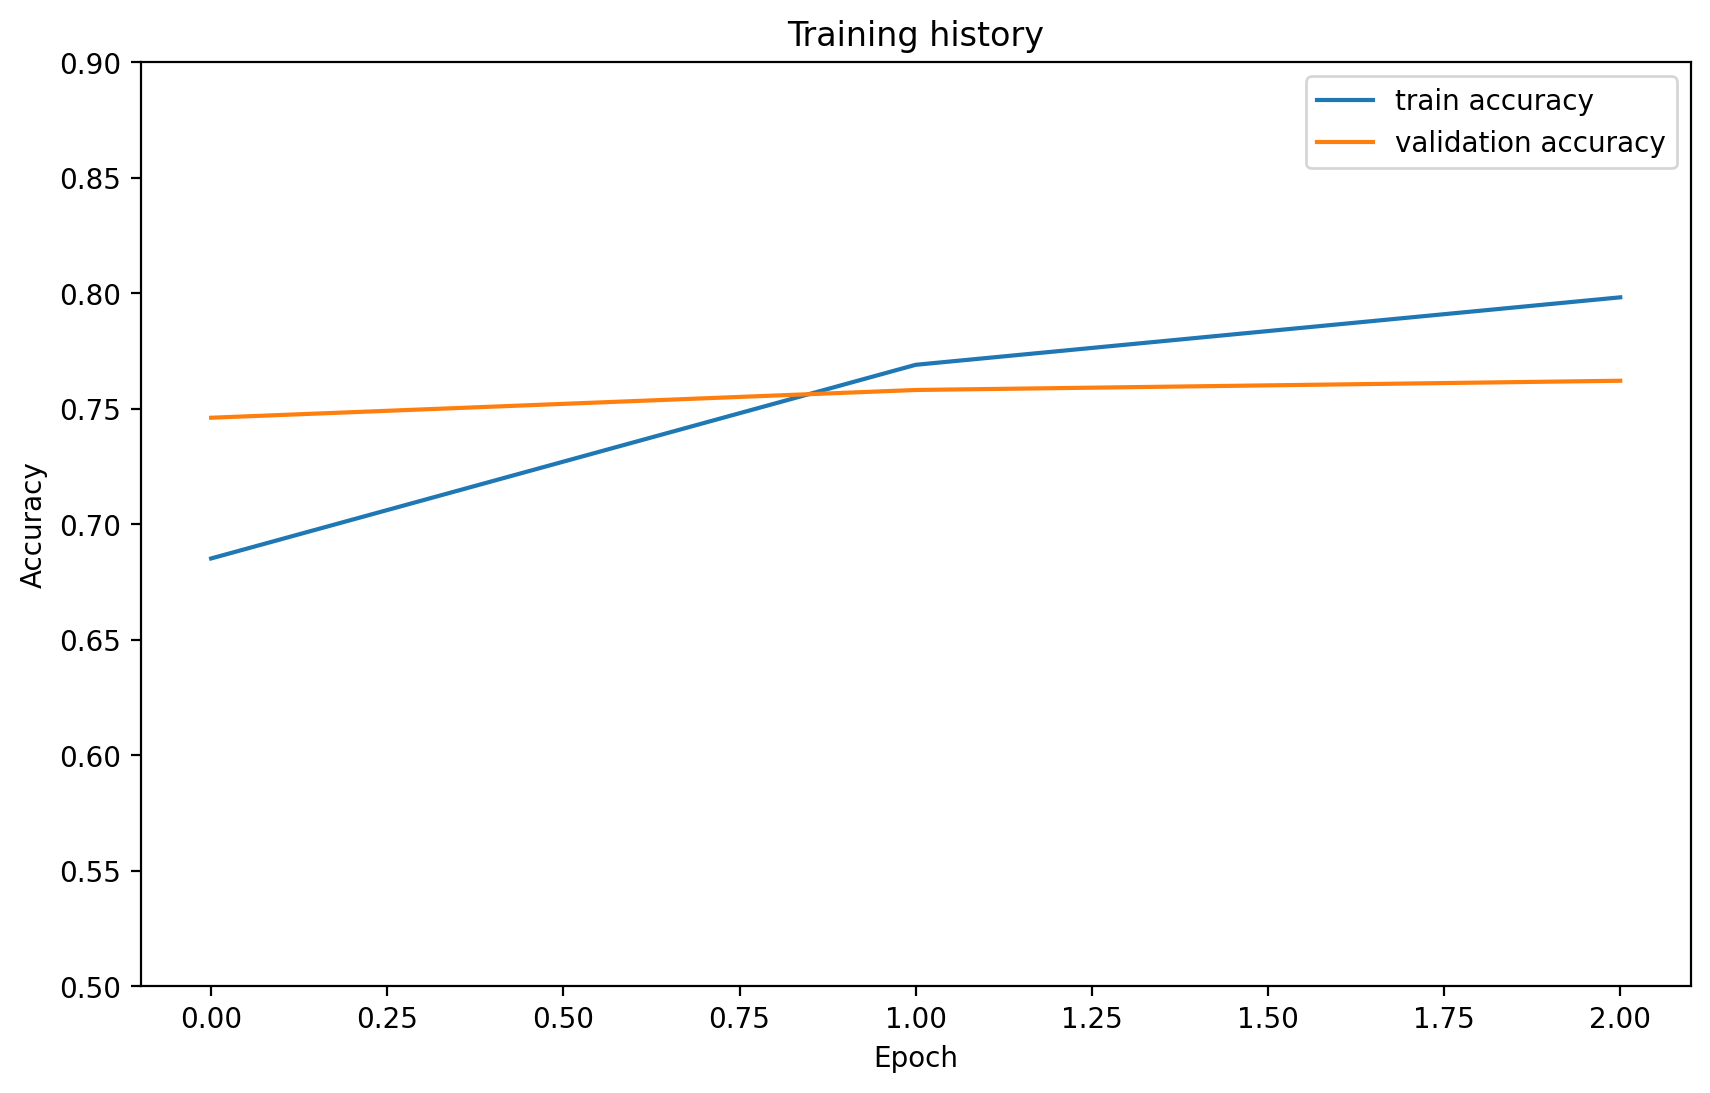

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Отрисуем результаты обучения
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 0.9])

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test),
  epoch
)

test_acc.item()

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


0.748

<div class="alert alert-info">

Обучение прошло успешно, мы получили хорошие значения метрик.

In [ ]:
# Функция получения предсказания
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

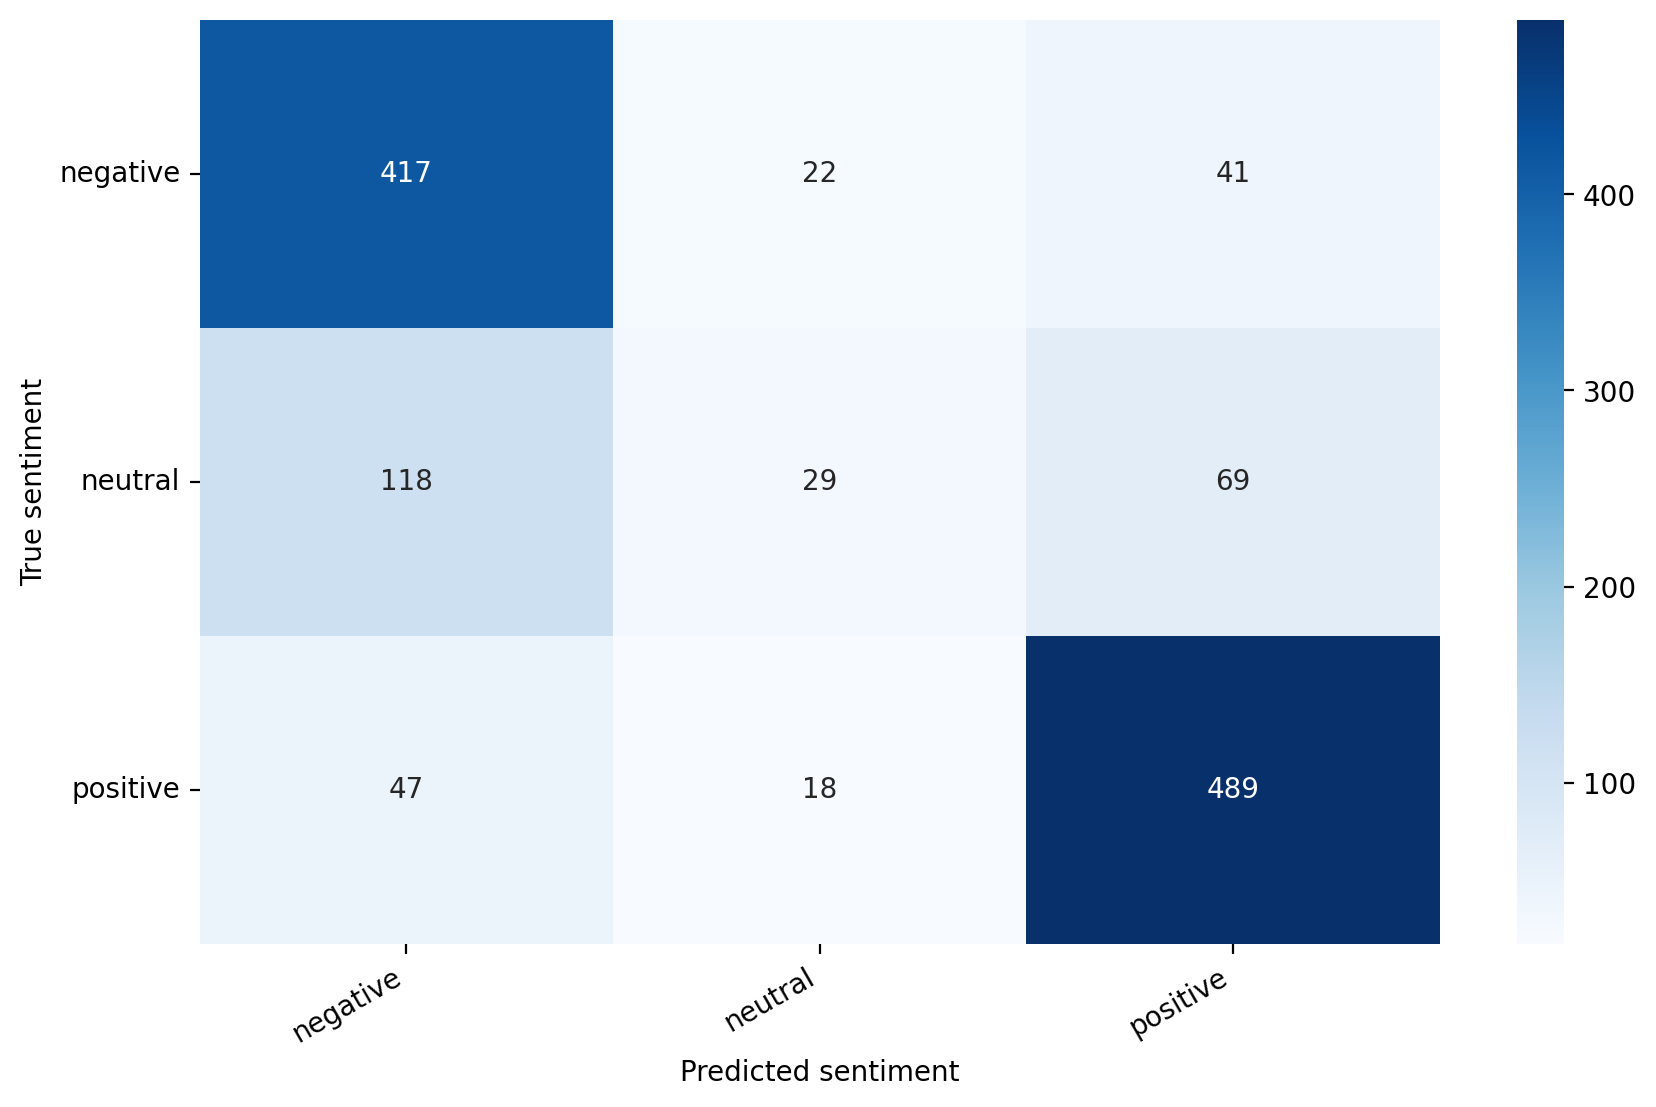

In [ ]:
# Функция отрисовки матрицы ошибок
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

<div class="alert alert-info">

Ну что ж, результат очень даже приличный. Поздравляем с успешным fine-tune!

In [ ]:
# Случайный комментарий
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
# Результат
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment: positive


# <center id="a2"> Fine-tune только классифицирующей головы

Давайте повторим предыдущий эксперимент. С той лишь разницей, что мы заморозим все веса BERT, кроме последнего классифицирующего слоя. Скорость обучения значительно вырастет, а вот что будет с качеством?

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Считаем функцию потерь и метрику на обучении
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        epoch
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Считаем функцию потерь и метрику на валидации
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        epoch
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Если модель на текущем шагу лучше, то сохраняем
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

writer.flush()
writer.close()

Epoch 1/3
----------


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Train loss 1.128078364118745 accuracy 0.4011604641856743


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Val loss 1.103714919090271 accuracy 0.4531625300240192

Epoch 2/3
----------


100%|██████████| 79/79 [01:31<00:00,  1.16s/it]


Train loss 1.130566275572475 accuracy 0.3939575830332133


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Val loss 1.103714919090271 accuracy 0.4531625300240192

Epoch 3/3
----------


100%|██████████| 79/79 [01:31<00:00,  1.16s/it]


Train loss 1.1276271403590334 accuracy 0.3955582232893158


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

Val loss 1.103714919090271 accuracy 0.4531625300240192



In [ ]:
# Отправляем на cpu
history['train_acc'] = [x.cpu() for x in history['train_acc']]
history['val_acc'] = [x.cpu() for x in history['val_acc']]

(0.0, 1.0)

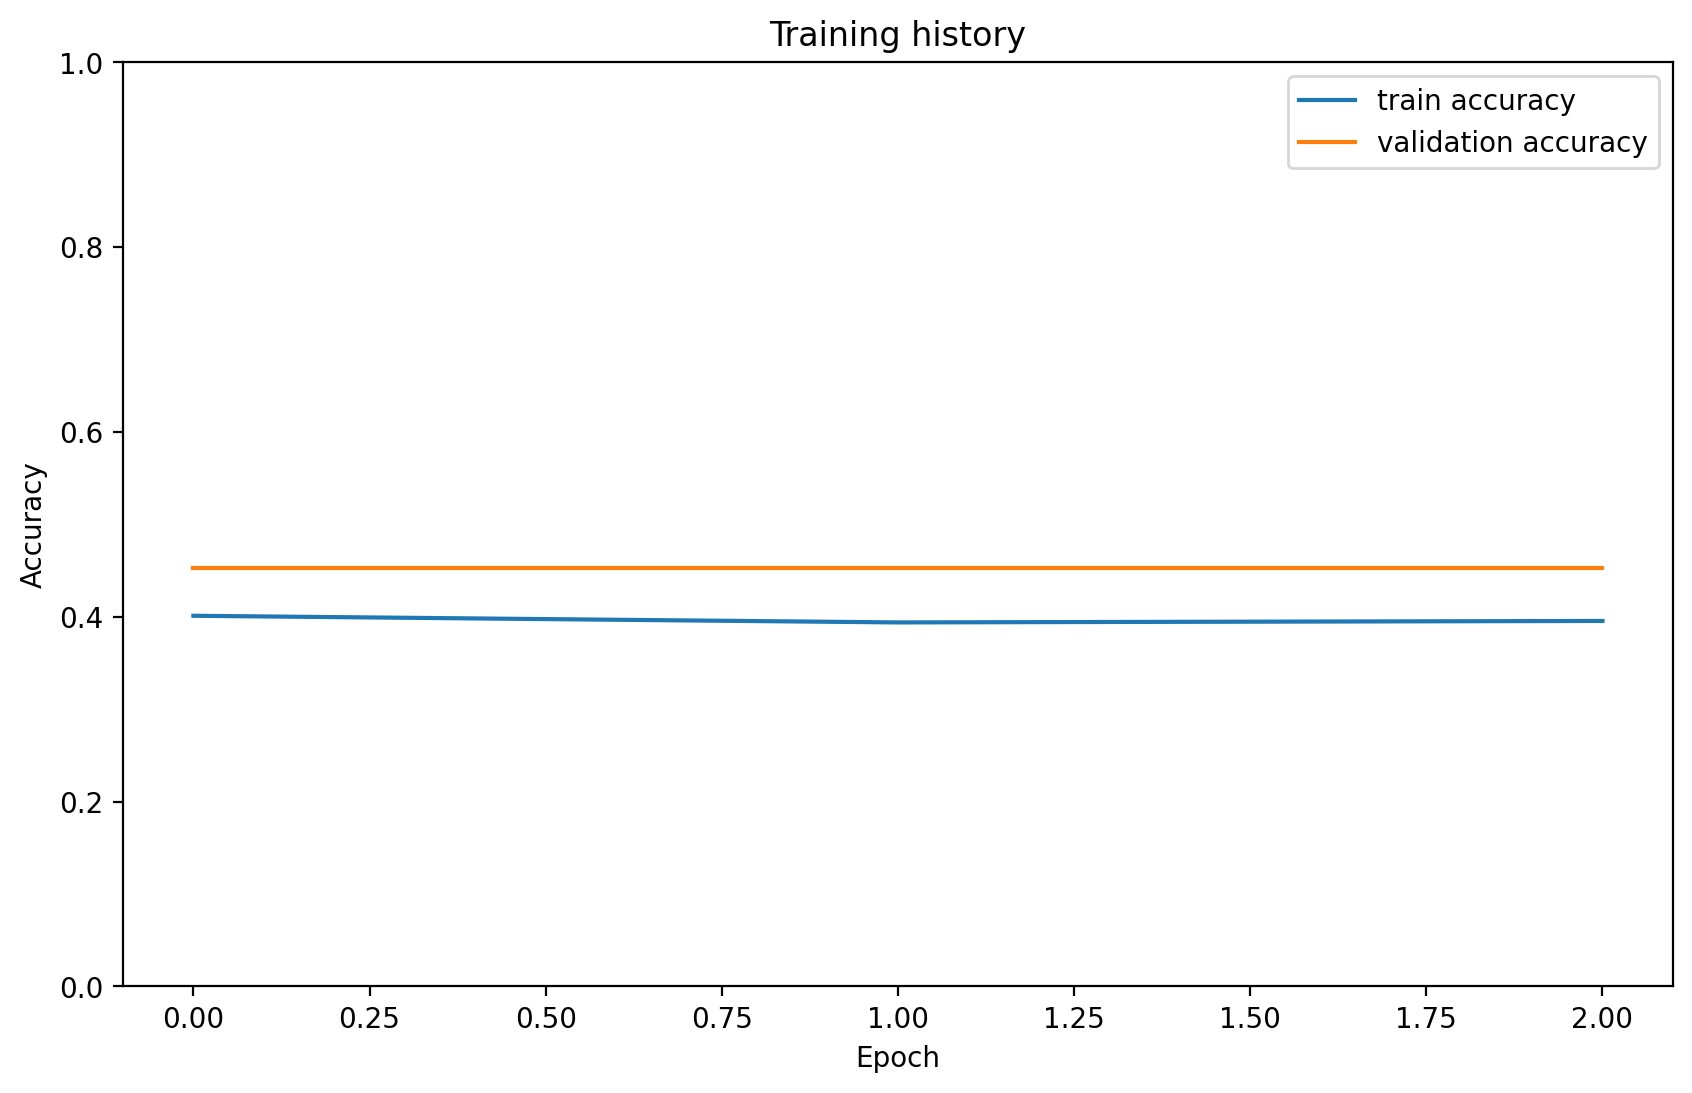

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Отрисуем результаты обучения
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test),
  epoch
)

test_acc.item()

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


0.44480000000000003

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

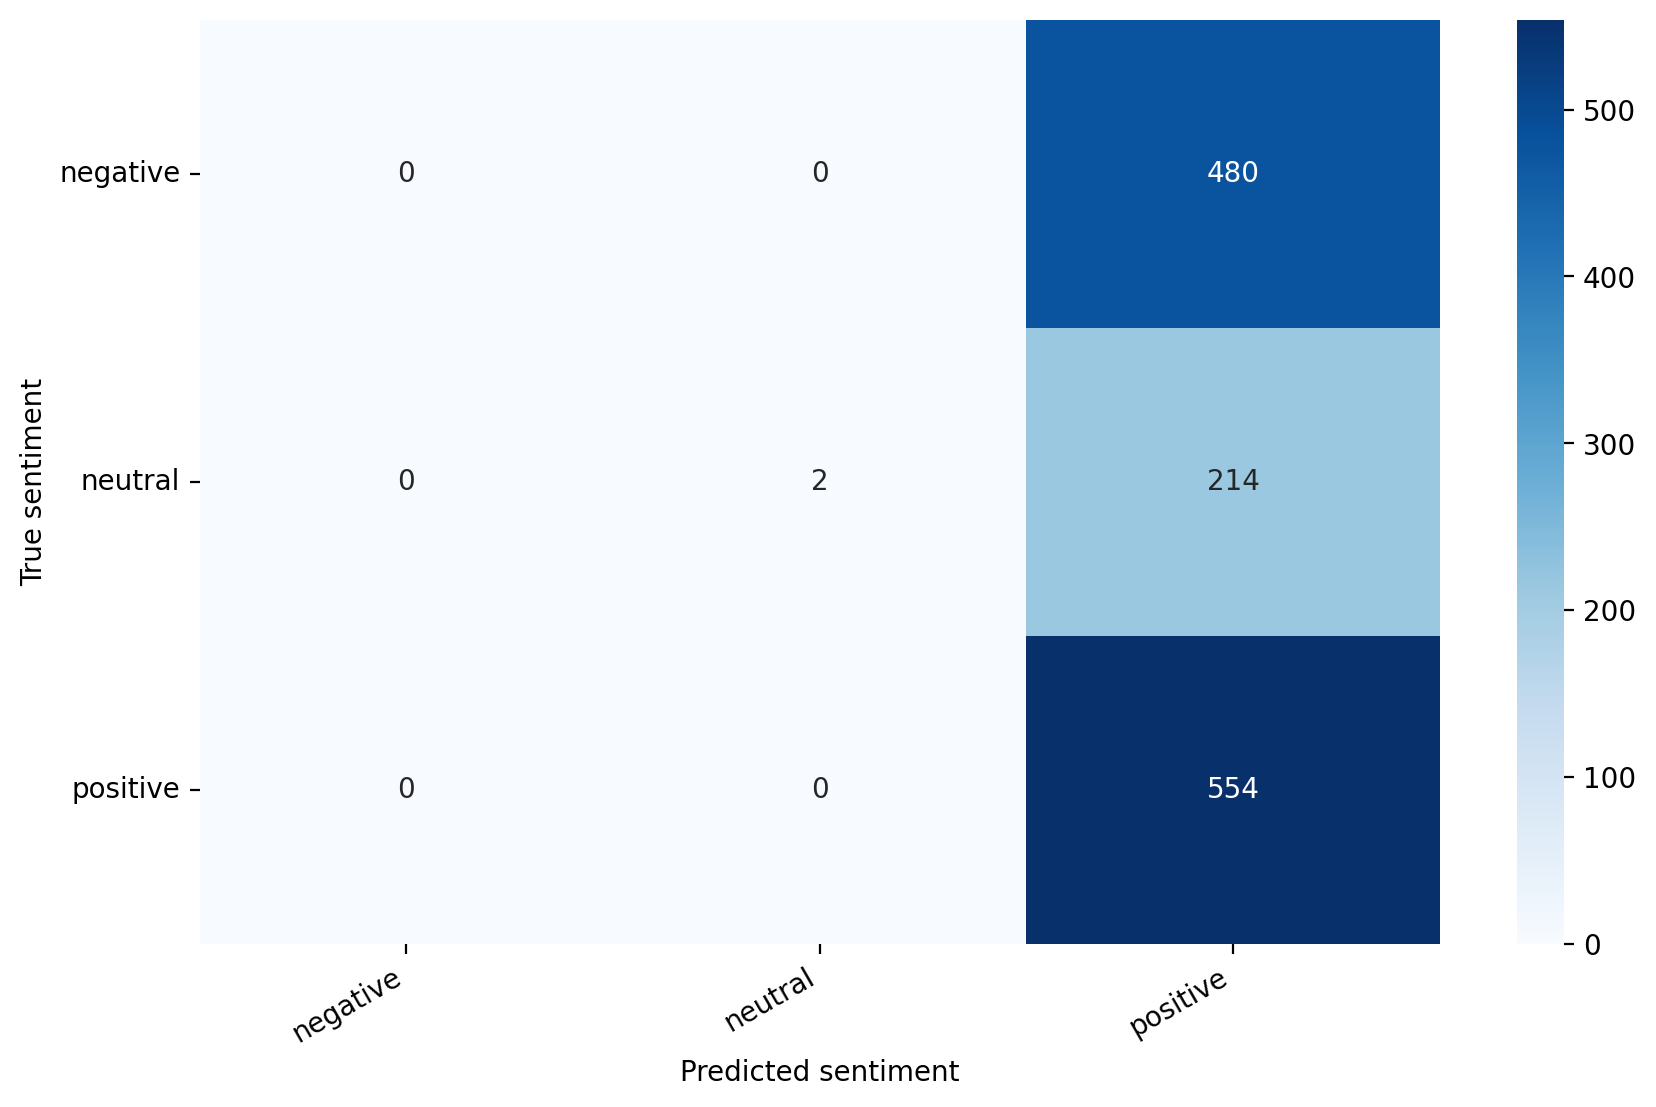

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

<div class="alert alert-warning">

Можно заметить, что качество стало значительно хуже. Как вы думаете, с чем это связано?